In [1]:
from IPython.display import HTML

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import zipfile
import logging
import fsspec
# import ujson
from glob import glob
import os

from azure.storage.blob import ContainerClient
import tempfile
from metpy import xarray

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

In [3]:
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:34149 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 32.00 GiB


### Do setup stuff to get file paths

In [4]:
tempdir = os.path.join(tempfile.gettempdir(), 'goes')
os.makedirs(tempdir, exist_ok=True)

product = 'ABI-L2-MCMIPF'
syear = '2020'; sday='003'; shour = '14'

storage_account_url = 'https://goeseuwest.blob.core.windows.net'
container_name = 'noaa-goes16'
goes_blob_root = storage_account_url + '/' + container_name + '/'

goes_container_client = ContainerClient(account_url=storage_account_url, container_name=container_name, credential=None)

prefix = product + '/' + syear + '/' + sday + '/' 
print('Finding blobs matching prefex: {}'.format(prefix))
generator = goes_container_client.list_blobs(name_starts_with=prefix)
blobs = []
for blob in generator:
    blobs.append(blob.name)


Finding blobs matching prefex: ABI-L2-MCMIPF/2020/003/


In [5]:
# fs = fsspec.filesystem("az", account_name='goeseuwest')

# urllist = ['az://noaa-goes16/' + u  for u in blobs]

In [6]:
fs = fsspec.filesystem("http")

urllist = [goes_blob_root + u + "#mode=bytes" for u in blobs]

In [7]:
urllist[0]

'https://goeseuwest.blob.core.windows.net/noaa-goes16/ABI-L2-MCMIPF/2020/003/00/OR_ABI-L2-MCMIPF-M6_G16_s20200030000215_e20200030009534_c20200030010031.nc#mode=bytes'

In [8]:
fobjlst = [fs.open(u) for u in urllist]

In [9]:
%%time
ds = xr.open_mfdataset(urllist,
                       combine='nested', concat_dim='t', 
                       coords='minimal', data_vars='minimal', compat='override',
                       parallel=True )

CPU times: user 57.2 s, sys: 12.5 s, total: 1min 9s
Wall time: 10min 28s


## Lat/lon

In [11]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [12]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))


In [29]:
ds = calc_latlon(ds)

<ipython-input-11-faaad4e12a01>:21: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [30]:
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

lats = (bottom, top)
lons = (left, right)

((x1, x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

In [31]:
%%time
subset = ds.sel(x=slice(x1, x2), y=slice(y2,y1))
subset

CPU times: user 33.1 ms, sys: 618 µs, total: 33.7 ms
Wall time: 32.4 ms


<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 144, x: 2440, y: 1020)
Coordinates: (12/39)
  * t                                       (t) datetime64[ns] 2020-01-03T00:...
  * y                                       (y) float32 0.126 0.126 ... 0.06896
  * x                                       (x) float32 -0.1144 ... 0.0222
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                      ...
    band_id_C13                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C14                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C15                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C16                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    lat                                     (y, x) float32 nan nan ... 23.34
    lon                                     (y, x) float32 nan nan ... -67.06
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(1, 1020, 2440), meta=np.ndarray>
    DQF_C01                                 (t, y, x) float32 dask.array<chunksize=(1, 1020, 2440), meta=np.ndarray>
    CMI_C02                                 (t, y, x) float32 dask.array<chunksize=(1, 1020, 2440), meta=np.ndarray>
    DQF_C02                                 (t, y, x) float32 dask.array<chunksize=(1, 1020, 2440), meta=np.ndarray>
    CMI_C03                                 (t, y, x) float32 dask.array<chunksize=(1, 1020, 2440), meta=np.ndarray>
    DQF_C03                                 (t, y, x) float32 dask.array<chunksize=(1, 1020, 2440), meta=np.ndarray>
    ...                                      ...
    mean_brightness_temperature_C16         (t) float64 260.0 260.0 ... 260.4
    std_dev_brightness_temperature_C16      (t) float64 16.11 16.07 ... 16.24
    percent_uncorrectable_GRB_errors        (t) float64 nan nan nan ... nan nan
    percent_uncorrectable_L0_errors         (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    dynamic_algorithm_input_data_container  (t) int32 -2147483647 ... -214748...
    algorithm_product_version_container     (t) int32 -2147483647 ... -214748...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2020-01-03T00:10:03.1Z
    time_coverage_start:       2020-01-03T00:00:21.5Z
    time_coverage_end:         2020-01-03T00:09:53.4Z
    timeline_id:               ABI Mode 6
    production_data_source:    n/a
    id:                        dbd5c45a-4b8d-4e8b-b23a-3223efbf905b

### Calculate true color
https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html

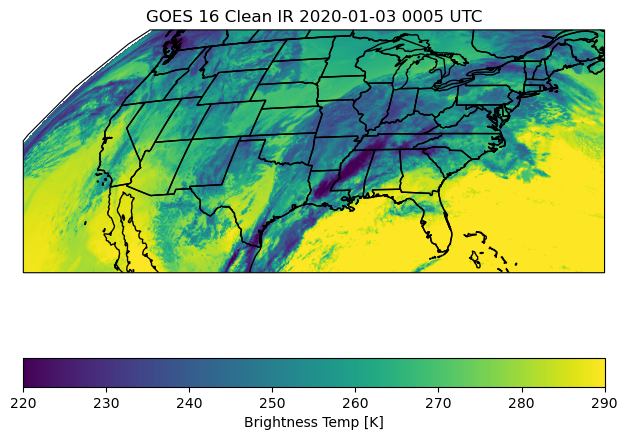

In [34]:
nt = len(subset.t)

from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(7.5,7.5), dpi=100)

dummy_channel = subset.metpy.parse_cf('CMI_C01')
x = dummy_channel.x; y = dummy_channel.y
ax = fig.add_subplot(111, projection = dummy_channel.metpy.cartopy_crs)

p = ax.imshow(subset.CMI_C13.isel(t=0), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
         vmin=220, vmax=290)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)
ax.add_feature(ccrs.cartopy.feature.STATES)

ts = pd.to_datetime(str(subset.t[0].values)).strftime("%Y-%m-%d %H%M UTC")
ax.set_title(f"GOES 16 Clean IR {ts}")
plt.colorbar(p, orientation='horizontal', label='Brightness Temp [K]', ax=ax)


def update_anim(i):
    ts = pd.to_datetime(str(subset.t[i].values)).strftime("%Y-%m-%d %H%M UTC")
    
    ax.clear()
    
    p = ax.imshow(subset.CMI_C13.isel(t=i), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
                 vmin=220, vmax=290)
    ax.set_title(f"GOES 16 Clean IR {ts}")
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS)
    ax.add_feature(ccrs.cartopy.feature.STATES)
#     plt.colorbar(p, orientation='horizontal', label='Brightness Temperature [K]', ax=ax)
    

    return p
  
# update_anim(1)
animator = FuncAnimation(fig, update_anim, frames=nt, interval=50)
# plt.show()


In [36]:
%time HTML(animator.to_html5_video())

CPU times: user 648 µs, sys: 137 µs, total: 785 µs
Wall time: 768 µs
